In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import re
import datetime
import pylab as pl
pl.style.use('fivethirtyeight')
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import statsmodels.api as sma

In [12]:
census = pd.read_csv('PST01.csv')
census = census.rename(columns={'PST045202D': 'Population'})

In [13]:
census.columns

Index([u'Areaname', u'STCOU', u'Population'], dtype='object')

In [14]:
carbon = pd.read_csv('carbon.csv')

In [15]:
carbon.columns

Index([u'State', u'County', u'FIPS', u'Total', u'Commercial', u'Industrial',
       u'Residential', u'Electricity Prod', u'Onroad', u'Cement', u'Aircraft',
       u'Airborne', u'Nonroad'],
      dtype='object')

In [16]:
merged = pd.merge(census, carbon, left_on='STCOU', right_on='FIPS')

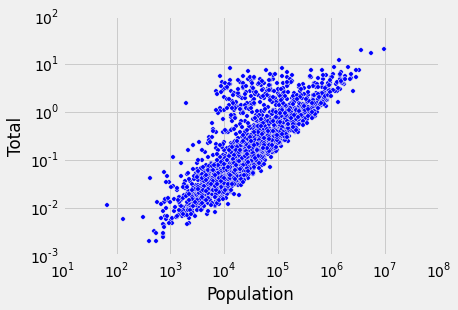

In [18]:
merged.plot('Population', 'Total', kind='scatter', logy=True, logx=True)

In [20]:
merged.describe()

,STCOU,Population,FIPS,Total,Commercial,Industrial,Residential,Electricity Prod,Onroad,Cement,Aircraft,Airborne,Nonroad
count,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000,3138.000000
mean,30435.328553,91710.801147,30435.328553,0.510080,0.021177,0.091057,0.032428,0.197242,0.127406,0.004018,0.005838,0.015271,0.015642
std,15134.945712,299313.711814,15134.945712,1.199037,0.077770,0.437060,0.108491,0.687677,0.325747,0.032664,0.025510,0.065612,0.034940
min,1001.000000,66.000000,1001.000000,0.001961,0.000000,0.000000,0.000000,0.000000,0.000088,0.000000,0.000000,0.000000,0.000004
25%,19001.500000,11172.500000,19001.500000,0.047465,0.001068,0.003498,0.003411,0.000000,0.021910,0.000000,0.000000,0.000000,0.003921
50%,29182.000000,24911.000000,29182.000000,0.115906,0.003260,0.014855,0.007771,0.000000,0.048480,0.000000,0.000956,0.002411,0.007759
75%,45084.500000,62334.250000,45084.500000,0.342149,0.011559,0.048551,0.020539,0.001932,0.108986,0.000000,0.003722,0.009374,0.013887
max,56045.000000,9717871.000000,56045.000000,21.316004,1.717594,9.890448,3.251092,7.406676,9.360510,0.849118,0.979744,2.462769,0.867329


In [26]:
merged.sort('Population', ascending=False).head(20)

,Areaname,STCOU,Population,State,County,FIPS,Total,Commercial,Industrial,Residential,Electricity Prod,Onroad,Cement,Aircraft,Airborne,Nonroad
199,"Los Angeles, CA",6037,9717871,CA,Los Angeles,6037,21.316004,0.276885,5.026491,1.904691,2.126320,9.360510,0.000000,0.499128,1.254651,0.867329
605,"Cook, IL",17031,5355574,IL,Cook,17031,16.972333,1.717594,2.009442,3.251092,1.171615,4.890368,0.000000,0.979744,2.462769,0.489710
2618,"Harris, TX",48201,3557879,TX,Harris,48201,19.419976,0.792881,9.890448,0.527812,2.526956,4.425204,0.000000,0.205406,0.516326,0.534942
98,"Maricopa, AZ",4013,3299127,AZ,Maricopa,4013,7.481091,0.689738,0.266782,0.259266,0.573111,4.027873,0.000000,0.305934,0.769021,0.589365
210,"Orange, CA",6059,2917106,CA,Orange,6059,5.329271,0.266585,0.354225,0.602420,0.255239,3.178229,0.000000,0.080855,0.203243,0.388474
217,"San Diego, CA",6073,2901235,CA,San Diego,6073,7.446142,1.423968,0.200159,0.268066,0.994226,3.631679,0.000000,0.151903,0.381836,0.394305
1846,"Kings, NY",36047,2477380,NY,Kings,36047,2.762536,0.304717,0.096474,1.263711,0.365362,0.591724,0.000000,0.000000,0.000000,0.140547
357,"Miami-Dade, FL",12086,2328122,FL,Miami-Dade,12086,5.129586,0.125658,0.562291,0.081097,0.653045,2.677214,0.352773,0.116171,0.292018,0.269319
2574,"Dallas, TX",48113,2280415,TX,Dallas,48113,6.366917,0.673756,0.878008,0.487922,0.734565,2.980259,0.000000,0.084866,0.213326,0.314215
1863,"Queens, NY",36081,2239457,NY,Queens,36081,5.011067,0.236345,0.105922,1.139530,2.043451,0.933499,0.000000,0.122319,0.307471,0.122529


In [25]:
merged[merged.STCOU==36047]

,Areaname,STCOU,Population,State,County,FIPS,Total,Commercial,Industrial,Residential,Electricity Prod,Onroad,Cement,Aircraft,Airborne,Nonroad
1846,"Kings, NY",36047,2477380,NY,Kings,36047,2.762536,0.304717,0.096474,1.263711,0.365362,0.591724,0,0,0,0.140547


In [29]:
mod = smf.ols(formula='Total ~ Population', data = merged).fit()
print mod.summary()

merged['Population2'] = merged['Population']**2
mod = smf.ols(formula='Total ~ Population + Population2', data = merged).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     3224.
Date:                Tue, 10 Nov 2015   Prob (F-statistic):               0.00
Time:                        15:50:24   Log-Likelihood:                -3912.3
No. Observations:                3138   AIC:                             7829.
Df Residuals:                    3136   BIC:                             7841.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.2485      0.016     15.806      0.0

In [30]:
merged['PerCapita'] = merged['Total']/merged['Population']

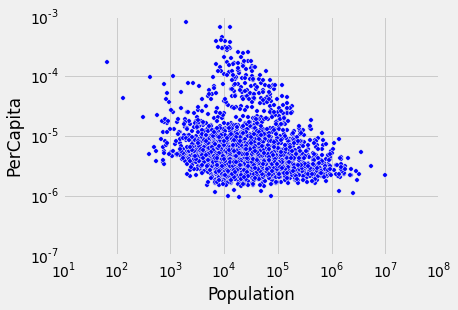

In [31]:
merged.plot('Population', 'PerCapita', kind='scatter', logy=True, logx=True)

                            OLS Regression Results                            
Dep. Variable:         log(PerCapita)   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     132.1
Date:                Tue, 10 Nov 2015   Prob (F-statistic):           5.58e-30
Time:                        16:21:01   Log-Likelihood:                -4003.0
No. Observations:                3138   AIC:                             8010.
Df Residuals:                    3136   BIC:                             8022.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept         -10.9133      0.112    -

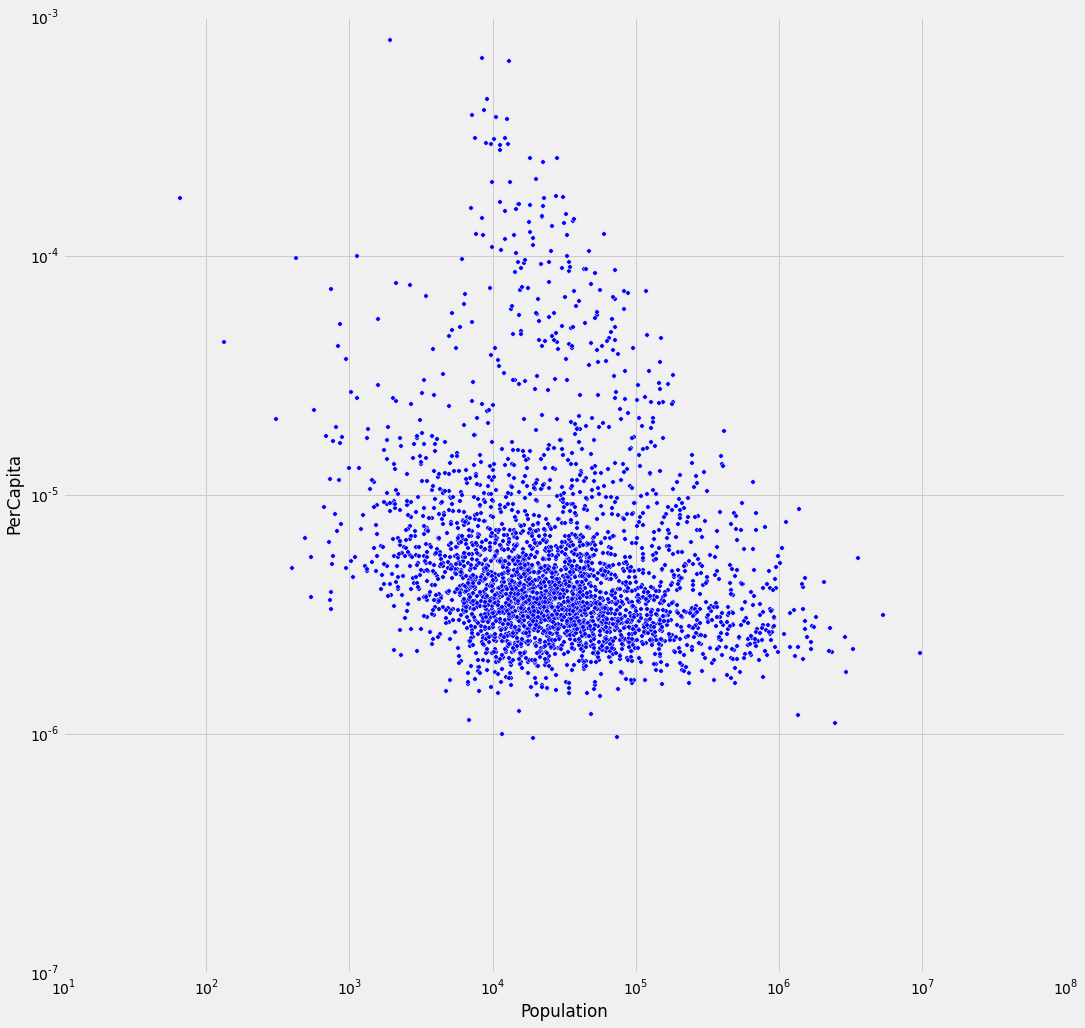

In [63]:
figure, ax = pl.subplots(figsize=(16,16))
#ax.scatter(streak, cycle)
#ax.set_xscale('log')
#ax.set_yscale('log')
merged.plot('Population', 'PerCapita', kind='scatter', ax=ax, logx=True, logy=True)

mod = smf.ols(formula='log(PerCapita) ~ log(Population)', data = merged).fit()
print mod.summary()

#x = np.logspace(2,9,100)
x = np.array([10,10**7])
y = mod.params[0] + x*mod.params[1]
print x,y
#ax.plot(x, y)
#abline_plot(model_results=mod, ax=ax, color='red')

#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_title('')
#ax.set_xlabel('Win Streak')
#ax.set_ylabel('311 Complaint Cycle')

In [64]:
mod.params[0]

-10.913348105405595

In [49]:
x

array([  1.00000000e+01,   1.01011091e+06,   2.02021182e+06,
         3.03031273e+06,   4.04041364e+06,   5.05051455e+06,
         6.06061545e+06,   7.07071636e+06,   8.08081727e+06,
         9.09091818e+06,   1.01010191e+07,   1.11111200e+07,
         1.21212209e+07,   1.31313218e+07,   1.41414227e+07,
         1.51515236e+07,   1.61616245e+07,   1.71717255e+07,
         1.81818264e+07,   1.91919273e+07,   2.02020282e+07,
         2.12121291e+07,   2.22222300e+07,   2.32323309e+07,
         2.42424318e+07,   2.52525327e+07,   2.62626336e+07,
         2.72727345e+07,   2.82828355e+07,   2.92929364e+07,
         3.03030373e+07,   3.13131382e+07,   3.23232391e+07,
         3.33333400e+07,   3.43434409e+07,   3.53535418e+07,
         3.63636427e+07,   3.73737436e+07,   3.83838445e+07,
         3.93939455e+07,   4.04040464e+07,   4.14141473e+07,
         4.24242482e+07,   4.34343491e+07,   4.44444500e+07,
         4.54545509e+07,   4.64646518e+07,   4.74747527e+07,
         4.84848536e+07,

In [52]:
np.logspace(2,9,100)

array([  1.00000000e+02,   1.17681195e+02,   1.38488637e+02,
         1.62975083e+02,   1.91791026e+02,   2.25701972e+02,
         2.65608778e+02,   3.12571585e+02,   3.67837977e+02,
         4.32876128e+02,   5.09413801e+02,   5.99484250e+02,
         7.05480231e+02,   8.30217568e+02,   9.77009957e+02,
         1.14975700e+03,   1.35304777e+03,   1.59228279e+03,
         1.87381742e+03,   2.20513074e+03,   2.59502421e+03,
         3.05385551e+03,   3.59381366e+03,   4.22924287e+03,
         4.97702356e+03,   5.85702082e+03,   6.89261210e+03,
         8.11130831e+03,   9.54548457e+03,   1.12332403e+04,
         1.32194115e+04,   1.55567614e+04,   1.83073828e+04,
         2.15443469e+04,   2.53536449e+04,   2.98364724e+04,
         3.51119173e+04,   4.13201240e+04,   4.86260158e+04,
         5.72236766e+04,   6.73415066e+04,   7.92482898e+04,
         9.32603347e+04,   1.09749877e+05,   1.29154967e+05,
         1.51991108e+05,   1.78864953e+05,   2.10490414e+05,
         2.47707636e+05,

In [65]:
10**mod.params[0]

1.2208207284135063e-11

In [73]:
merged['logPopulation'] = np.log(merged.Population)
merged['logPerCapita'] = np.log(merged.PerCapita)
merged['logPopulation2'] = merged['logPopulation']**2

                            OLS Regression Results                            
Dep. Variable:           logPerCapita   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     132.1
Date:                Tue, 10 Nov 2015   Prob (F-statistic):           5.58e-30
Time:                        18:47:33   Log-Likelihood:                -4003.0
No. Observations:                3138   AIC:                             8010.
Df Residuals:                    3136   BIC:                             8022.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       -10.9133      0.112    -97.511

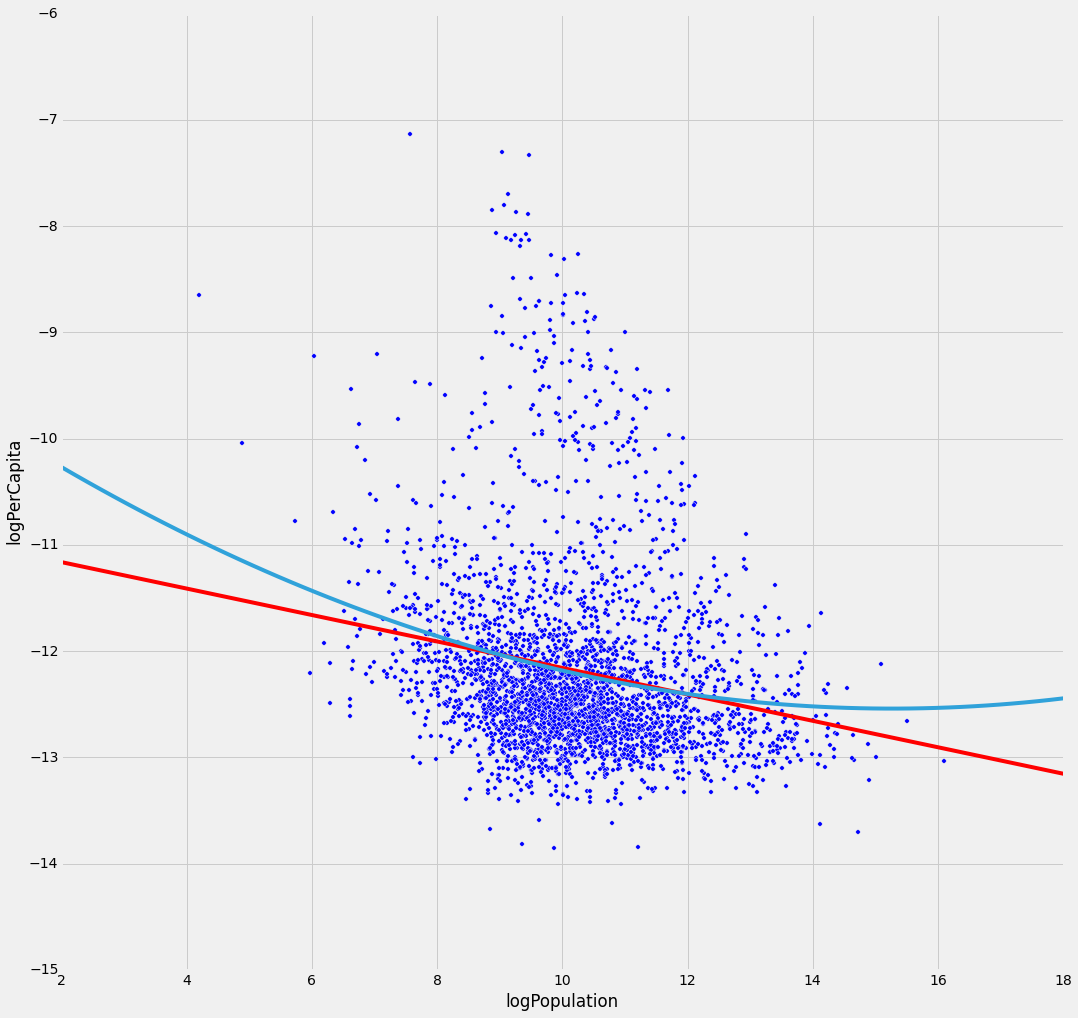

In [77]:
figure, ax = pl.subplots(figsize=(16,16))
#ax.scatter(streak, cycle)
#ax.set_xscale('log')
#ax.set_yscale('log')
merged.plot('logPopulation', 'logPerCapita', kind='scatter', ax=ax)

mod = smf.ols(formula='logPerCapita ~ logPopulation', data = merged).fit()
print mod.summary()

abline_plot(model_results=mod, ax=ax, color='red')

mod = smf.ols(formula='logPerCapita ~ logPopulation + logPopulation2', data = merged).fit()
print mod.summary()

#x = np.logspace(2,9,100)
#x = np.array([10,10**7])
x = np.linspace(0,20,100)
y = mod.params[0] + x*mod.params[1] + (x**2)*mod.params[2]
#print x,y
ax.plot(x, y)
#abline_plot(model_results=mod, ax=ax, color='red')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_title('')
#ax.set_xlabel('Win Streak')
#ax.set_ylabel('311 Complaint Cycle')